# Embedding approximation and PCA initialisation using **imitation**

This is a demonstration of **imitation loss**.
This approach initialises the ViVAE model parameters according to an existing, trained DR model, effectively biasing the embedding process.
Through computing L2 distances between points embedded by the ViVAE model's encoder and their corresponding embedding by the reference model, we quickly optimise the embedding to match the desired starting point before proceeding to train ViVAE fully.
We then continue with the rest of the training procedure.

If we are training our VAE on PCA-reduced data, we can apply a trivial pre-training using the embedding obtained from taking the top 2 principal components, which we obtain by taking the first two dimensions of the input.
This makes the process very fast.

<hr>

In this case study, we PCA-initialise and train a decoder-less ViVAE model to create a 2-dimensional embedding of the [*Reed*](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637) Human Breast Atlas immune cells dataset.

<hr>

## **0.** Set-up

First, let's import required libraries and load in data.

In [1]:
import numpy as np
import torch
import ViVAE
import ViScore
import matplotlib.pyplot as plt

The data below is downloaded from CELLxGENE and pre-processed, as described [here](https://github.com/saeyslab/ViScore/tree/main/benchmarking) and in our manuscript.

In [2]:
input          = np.load('../../ViScore/benchmarking/data/Reed_input.npy', allow_pickle=True)
input_denoised = np.load('../../ViScore/benchmarking/data/Reed_input_denoised.npy', allow_pickle=True)
labs           = np.load('../../ViScore/benchmarking/data/Reed_labels.npy', allow_pickle=True)

The extraction of top 2 principal components from input data is implemented in the `FirstNDimsExtractor` class in ViVAE.
**This assumes that the input consists of PCA-reduced data, with columns ordered by decreasing PC eigenvalue.**

In [3]:
from ViVAE.losses import FirstNDimsExtractor
ref_model = FirstNDimsExtractor(latent_dim=2)

## **1.** Pre-training

We will now create a ViVAE model and pre-train it to imitate the projection of data obtained from taking the first 2 principal components.
To keep things fast, we do not train a decoder (`lam_recon=0.`).

In [4]:
np.random.seed(42)
torch.manual_seed(42)
model = ViVAE.ViVAE(input_dim=input.shape[1], random_state=42)
model.fit(X=input_denoised, n_epochs=10, batch_size=2048, lam_recon=0., lam_kldiv=1., lam_mds=0., lam_imit=1., ref_model=ref_model)

Epoch 1/10	recon: 0.0000	kldiv: 0.0326	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 89.0792
Epoch 2/10	recon: 0.0000	kldiv: 0.0171	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 41.7046
Epoch 3/10	recon: 0.0000	kldiv: 0.0207	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 19.9894
Epoch 4/10	recon: 0.0000	kldiv: 0.0362	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 9.3950
Epoch 5/10	recon: 0.0000	kldiv: 0.0314	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 5.8536
Epoch 6/10	recon: 0.0000	kldiv: 0.0264	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 4.1053
Epoch 7/10	recon: 0.0000	kldiv: 0.0235	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 2.7067
Epoch 8/10	recon: 0.0000	kldiv: 0.0230	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 1.2603
Epoch 9/10	recon: 0.0000	kldiv: 0.0213	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 0.6023
Epoch 10/10	recon: 0.0000	kldiv: 0.0196	geom: 0.0000	egeom: 0.0000	mds: 0.0000	imit: 0.3448


Let's verify that the embedding obtained by the pre-trained ViVAE model and low-dimensional PCA are indeed similar.

In [5]:
fig_pc, ax_pc = ViVAE.plot_embedding(input_denoised[:,range(2)], labs, show=False, figsize=(4,4))
ax_pc.get_legend().remove()
ax_pc.set_title('Top 2 PCs')
fig_pc.savefig('imitation_pc.png', dpi=600)

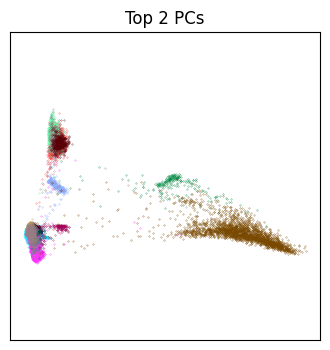

In [6]:
fig_pc

In [7]:
emb0 = model.transform(input_denoised)
fig0, ax0 = ViVAE.plot_embedding(emb0, labs, show=False, figsize=(4,4))
ax0.get_legend().remove()
ax0.set_title('ViVAE imitating top 2 PCs')
fig0.savefig('imitation_vivae0.png', dpi=600)

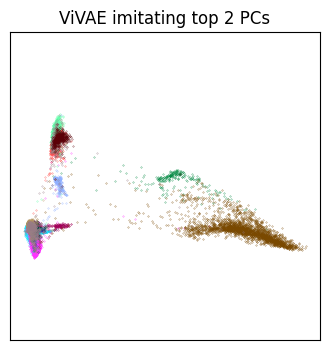

In [8]:
fig0

## **2.** Continued training

We can now continue the training process by optimising stochastic-MDS along with KL divergence from latent prior.

In [9]:
model.fit(X=input_denoised, n_epochs=20, batch_size=2048, lam_recon=0., lam_kldiv=1., lam_mds=100., lam_imit=0., ref_model=ref_model)

Epoch 1/20	recon: 0.0000	kldiv: 0.1571	geom: 0.0000	egeom: 0.0000	mds: 77.3192	imit: 0.0000
Epoch 2/20	recon: 0.0000	kldiv: 0.0810	geom: 0.0000	egeom: 0.0000	mds: 23.9341	imit: 0.0000
Epoch 3/20	recon: 0.0000	kldiv: 0.0553	geom: 0.0000	egeom: 0.0000	mds: 14.2010	imit: 0.0000
Epoch 4/20	recon: 0.0000	kldiv: 0.0397	geom: 0.0000	egeom: 0.0000	mds: 9.6207	imit: 0.0000
Epoch 5/20	recon: 0.0000	kldiv: 0.0317	geom: 0.0000	egeom: 0.0000	mds: 7.1808	imit: 0.0000
Epoch 6/20	recon: 0.0000	kldiv: 0.0262	geom: 0.0000	egeom: 0.0000	mds: 5.9416	imit: 0.0000
Epoch 7/20	recon: 0.0000	kldiv: 0.0231	geom: 0.0000	egeom: 0.0000	mds: 5.0676	imit: 0.0000
Epoch 8/20	recon: 0.0000	kldiv: 0.0201	geom: 0.0000	egeom: 0.0000	mds: 4.2637	imit: 0.0000
Epoch 9/20	recon: 0.0000	kldiv: 0.0179	geom: 0.0000	egeom: 0.0000	mds: 3.7370	imit: 0.0000
Epoch 10/20	recon: 0.0000	kldiv: 0.0164	geom: 0.0000	egeom: 0.0000	mds: 3.3357	imit: 0.0000
Epoch 11/20	recon: 0.0000	kldiv: 0.0147	geom: 0.0000	egeom: 0.0000	mds: 3.0060	imit: 0

In [10]:
emb1 = model.transform(input_denoised)
fig1, ax1 = ViVAE.plot_embedding(emb1, labs, show=False, figsize=(4,4))
ax1.get_legend().remove()
ax1.set_title('Fully trained ViVAE')
fig1.savefig('imitation_vivae1.png', dpi=600)

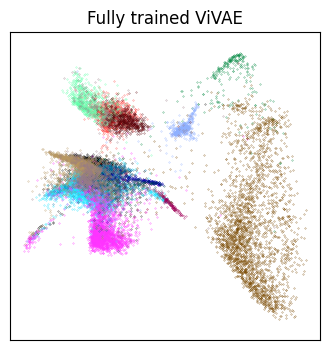

In [11]:
fig1